##### Copyright 2018 The TensorFlow Authors.

In [5]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [6]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [7]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [8]:
dataset, info = tfds.load('wikipedia_toxicity_subtypes', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset wikipedia_toxicity_subtypes downloaded and prepared to ~/tensorflow_datasets/wikipedia_toxicity_subtypes/EnglishSubtypes/0.3.1. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

Initially this returns a dataset of (text, label pairs):

In [9]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'"\nThanks Xeno. -  \xe2\x80\xa2 Talk \xe2\x80\xa2 "'
label:  0.0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Just needs someone to write it - how about you?'
 b"Accusation of plagiarism =\n\nYnhockey, you have made a rather serious accusation  plagiarism  against me: .\n\nHowever, plagiarism occurs when someone else's material is misrepresented as one own's work. How can my edits be plagiarism, since I clearly referenced the source material  Haaretz?  \n\nI think you have confused plagiarism and copyright. From plagiarism:\n\nPlagiarism is not copyright infringement. While both terms may apply to a particular act, they are different transgressions. Copyright infringement is a violation of the rights of a copyright holder, when material protected by copyright is used without consent. On the other hand, plagiarism is concerned with the unearned increment to the plagiarizing author's reputation that is achieved through false claims of authorship.\nContents\n\nYou wil find that using the 2 sentences in question fall under fair use.\n\nRegardless, plagiarism is a serious and, in this ca

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [13]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'you', 'i', 'is',
       'that', 'in', 'it', 'for', 'this', 'not', 'on', 'be', 'as', 'have'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [15]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 51, 340, 154, ...,   0,   0,   0],
       [  1,   4,   1, ...,   0,   0,   0],
       [275, 141,   6, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [16]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Just needs someone to write it - how about you?'
Round-trip:  just needs someone to write it how about you                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Original:  b"Accusation of plagiarism =\n\nYnhockey, you have made a rather serious accusa

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [17]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [18]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [19]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.0212523]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [20]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.02125229]


Compile the Keras model to configure the training process:

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [22]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
2494/2494 [==============================] - 153s 58ms/step - loss: 0.2105 - accuracy: 0.9294 - val_loss: 0.2261 - val_accuracy: 0.9198
Epoch 2/10
2494/2494 [==============================] - 143s 57ms/step - loss: 0.1446 - accuracy: 0.9487 - val_loss: 0.2051 - val_accuracy: 0.9286
Epoch 3/10
2494/2494 [==============================] - 144s 58ms/step - loss: 0.1401 - accuracy: 0.9498 - val_loss: 0.2128 - val_accuracy: 0.9245
Epoch 4/10
2494/2494 [==============================] - 143s 57ms/step - loss: 0.1380 - accuracy: 0.9503 - val_loss: 0.1988 - val_accuracy: 0.9323
Epoch 5/10
2494/2494 [==============================] - 141s 57ms/step - loss: 0.1365 - accuracy: 0.9500 - val_loss: 0.2089 - val_accuracy: 0.9302
Epoch 6/10
2494/2494 [==============================] - 142s 57ms/step - loss: 0.1354 - accuracy: 0.9504 - val_loss: 0.2072 - val_accuracy: 0.9307
Epoch 7/10
2494/2494 [==============================] - 142s 57ms/step - loss: 0.1338 - accuracy: 0.9504 - val_loss: 0

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1000/1000 [==============================] - 42s 42ms/step - loss: 0.2134 - accuracy: 0.9301
Test Loss: 0.213371142745018
Test Accuracy: 0.930116593837738


(0.0, 0.23089056089520454)

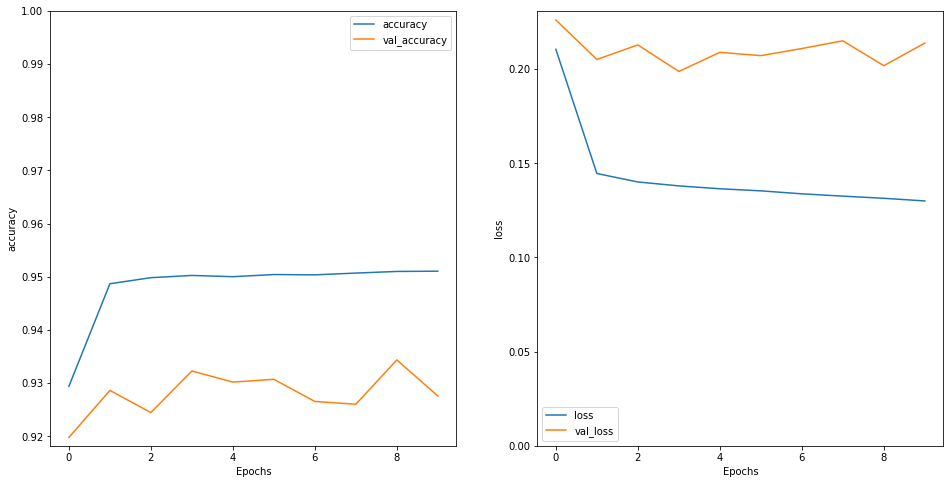

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [55]:
sample_text1 = ("You are a moron")
sample_text2 = ("You are disgusting")
sample_text3 = ("This was amazing!")
sample_text4 = ("Really appreciate this!")


predictions1 = model.predict(np.array([sample_text1]))
predictions2 = model.predict(np.array([sample_text2]))
predictions3 = model.predict(np.array([sample_text3]))
predictions4 = model.predict(np.array([sample_text4]))

print("Results from the saved model")
print(predictions1)
print(predictions2)
print(predictions3)
print(predictions4)

Results from the saved model
[[5.0210967]]
[[0.05212127]]
[[-2.0811937]]
[[-6.3489327]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [26]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
2494/2494 [==============================] - 258s 98ms/step - loss: 0.2100 - accuracy: 0.9301 - val_loss: 0.1841 - val_accuracy: 0.9339
Epoch 2/10
2494/2494 [==============================] - 238s 95ms/step - loss: 0.1495 - accuracy: 0.9482 - val_loss: 0.2197 - val_accuracy: 0.9219
Epoch 3/10
2494/2494 [==============================] - 235s 94ms/step - loss: 0.1440 - accuracy: 0.9488 - val_loss: 0.2158 - val_accuracy: 0.9276
Epoch 4/10
2494/2494 [==============================] - 238s 95ms/step - loss: 0.1411 - accuracy: 0.9491 - val_loss: 0.2083 - val_accuracy: 0.9286
Epoch 5/10
2494/2494 [==============================] - 242s 97ms/step - loss: 0.1394 - accuracy: 0.9493 - val_loss: 0.2098 - val_accuracy: 0.9281
Epoch 6/10
2494/2494 [==============================] - 239s 96ms/step - loss: 0.1378 - accuracy: 0.9496 - val_loss: 0.2076 - val_accuracy: 0.9292
Epoch 7/10
2494/2494 [==============================] - 238s 95ms/step - loss: 0.1362 - accuracy: 0.9498 - val_loss: 0

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1000/1000 [==============================] - 61s 61ms/step - loss: 0.2142 - accuracy: 0.9313
Test Loss: 0.21420226991176605
Test Accuracy: 0.9312732219696045


In [57]:
sample_text1 = ("You are a moron")
sample_text2 = ("You are disgusting")
sample_text3 = ("This was amazing!")
sample_text4 = ("Really appreciate this!")


predictions1 = model.predict(np.array([sample_text1]))
predictions2 = model.predict(np.array([sample_text2]))
predictions3 = model.predict(np.array([sample_text3]))
predictions4 = model.predict(np.array([sample_text4]))

print("Results from the saved model")
print(predictions1)
print(predictions2)
print(predictions3)
print(predictions4)

Results from the saved model
[[5.0210967]]
[[0.05212127]]
[[-2.0811937]]
[[-6.3489327]]


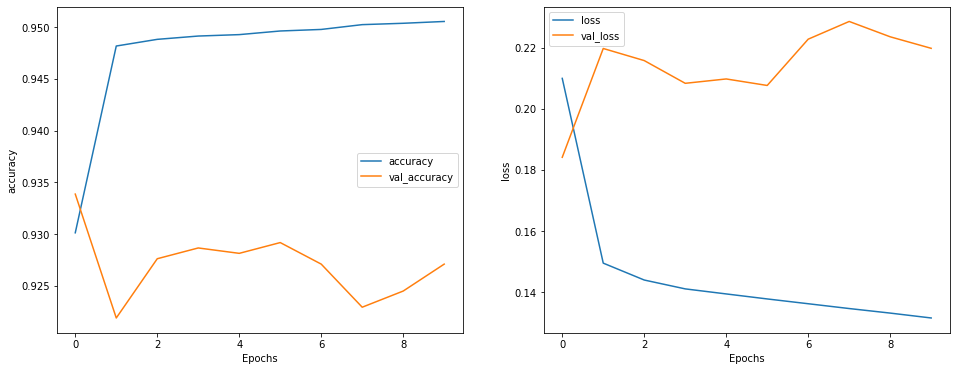

In [31]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
